In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import numpy as np
from tqdm.auto import tqdm
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertPreTrainedModel
from opencc import OpenCC
from morphert.model import *
from morphert.utils import compute_metric

t2s = OpenCC('t2s')
N = 500000

## Preprocessing Embeddings

In [4]:
import json
with open("../data/train_test_split_500k.json", "r") as fin:
    idxs = json.load(fin)
    train_idxs = idxs["train"]
    test_idxs = idxs["test"]

In [5]:
with open("../data/tencent_small_500k.pkl", "rb") as fin:
    (vocabs, embs) = pickle.load(fin)

In [7]:
vocabs[6558], embs[6558][:10]

('说什么',
 array([ 0.11927852, -0.12477621, -0.00780427, -0.20220207, -0.12248462,
         0.09576039, -0.1549168 , -0.05301735,  0.02143643,  0.1200113 ]))

## Prepare Dataset

In [8]:
train_dataset = MorphertDataset(train_idxs, vocabs, embs)
test_dataset = MorphertDataset(test_idxs, vocabs, embs)

In [9]:
len(train_dataset), len(test_dataset)

(490000, 10000)

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

## Evaluation

In [11]:
base_dir = "../data"
model = MorphertModel.from_pretrained(base_dir + "/morphert_500k")
collator_fn = DataCollator(tokenizer)
model = model.to("cuda")

### Training set predictions

In [12]:
rng = np.random.RandomState(123)
sub_idxs = np.arange(len(train_idxs))
rng.shuffle(sub_idxs)
sub_train = MorphertDataset(sub_idxs[:10000], vocabs, embs)
sub_train_emb = np.vstack([sub_train[i]["vec"] for i in range(len(sub_train))])

In [15]:
model.eval()
sub_train_loader = DataLoader(sub_train, collate_fn=collator_fn, batch_size=16, shuffle=True)
n_correct = 0
n_items = 0
with torch.no_grad():
    for batch_x in tqdm(sub_train_loader):        
        out = model(**batch_x)
        ref_words = batch_x["words"]
        pred_vecs = out.predictions.cpu().numpy()
        n_correct_x = compute_metric(ref_words, pred_vecs, sub_train_emb, sub_train)
        n_correct += n_correct_x
        n_items += len(ref_words)
print("Train(subsample) Acc: {:.4f}".format(n_correct / n_items))

Train(subsample) Acc: 0.7062


### Test eval

In [16]:
test_dataset = MorphertDataset(test_idxs, vocabs, embs)
test_emb = np.vstack([test_dataset[i]["vec"] for i in range(len(test_dataset))])
test_loader = DataLoader(test_dataset, collate_fn=collator_fn, batch_size=16, shuffle=False)

In [17]:
model.eval()
n_correct = 0
n_items = 0
with torch.no_grad():
    for batch_x in tqdm(test_loader):        
        out = model(**batch_x)
        ref_words = batch_x["words"]
        pred_vecs = out.predictions.cpu().numpy()
        n_correct_x = compute_metric(ref_words, pred_vecs, test_emb, test_dataset)
        n_correct += n_correct_x
        n_items += len(ref_words)    
print("Test Acc: {:.4f}".format(n_correct / n_items))

  0%|          | 0/625 [00:00<?, ?it/s]

Test Acc: 0.6693


### First K item accuracies
* k = 500, .89
* k = 1000, .82
* k = 2000, .78
* k = 6000, .70

In [13]:
k = 6000
testK_dataset = MorphertDataset(sorted(test_idxs)[:k], vocabs, embs)
testK_emb = np.vstack([testK_dataset[i]["vec"] for i in range(len(testK_dataset))])
testK_loader = DataLoader(testK_dataset, collate_fn=collator_fn, batch_size=16, shuffle=False)

In [14]:
model.eval()
n_correct = 0
n_items = 0
with torch.no_grad():
    for batch_x in tqdm(testK_loader):        
        out = model(**batch_x)
        ref_words = batch_x["words"]
        pred_vecs = out.predictions.cpu().numpy()
        n_correct_x = compute_metric(ref_words, pred_vecs, testK_emb, testK_dataset)
        n_correct += n_correct_x
        n_items += len(ref_words)    
print("Test1k Acc: {:.4f}".format(n_correct / n_items))

  0%|          | 0/375 [00:00<?, ?it/s]

Test1k Acc: 0.6998


In [15]:
from collections import Counter
Counter(len(x["word"]) for x in testK_dataset).most_common(5)

[(2, 1817), (4, 1794), (3, 1299), (5, 428), (6, 230)]

In [16]:
k = 6000
bisyll_idx = [x for x in sorted(test_idxs) if 1<len(vocabs[x])<=4]
bisyll_dataset = MorphertDataset(bisyll_idx[:k], vocabs, embs)
bisyll_emb = np.vstack([bisyll_dataset[i]["vec"] for i in range(len(bisyll_dataset))])
bisyll_loader = DataLoader(bisyll_dataset, collate_fn=collator_fn, batch_size=16, shuffle=False)

In [17]:
from collections import Counter
Counter(len(x["word"]) for x in bisyll_dataset)

Counter({2: 2076, 3: 1595, 4: 2329})

In [18]:
model.eval()
n_correct = 0
n_items = 0
with torch.no_grad():
    for batch_x in tqdm(bisyll_loader):        
        out = model(**batch_x)
        ref_words = batch_x["words"]
        pred_vecs = out.predictions.cpu().numpy()
        n_correct_x = compute_metric(ref_words, pred_vecs, bisyll_emb, bisyll_dataset)
        n_correct += n_correct_x
        n_items += len(ref_words)    
print("Bisyll Acc: {:.4f}".format(n_correct / n_items))

  0%|          | 0/375 [00:00<?, ?it/s]

Bisyll Acc: 0.7222


## Prediction Exploration

In [19]:
full_ds = MorphertDataset(np.arange(N), vocabs, embs)
full_emb = np.vstack([full_ds[i]["vec"] for i in range(N)])

In [44]:
from morphert import (get_predict_neighbors_fn, 
                      get_predict_vectors_fn, 
                      get_print_neighbors_fn,
                      get_predict_from_token_fn)
from morphert import compute_space_indices

In [45]:
predict_neighbors = get_predict_neighbors_fn(tokenizer, model, full_emb, full_ds)
print_neighbors = get_print_neighbors_fn(tokenizer, model, full_emb, full_ds)
predict_vectors = get_predict_vectors_fn(tokenizer, model)
predict_from_token = get_predict_from_token_fn(tokenizer, model)

In [46]:
print_neighbors(["政府", "電影", "鍵盤", "歡天喜地", "欢天喜地", "無三不成禮", "傅潘達"])

  政府: 政府 政府部门 是政府 财政 部门
  電影: 電影 劇情 電視劇 紀錄片 喜劇
  鍵盤: 鍵盤 電腦 開關 機器 鍵
* 歡天喜地: 快樂 開心 歡樂 慶祝 聯
  欢天喜地: 欢天喜地 欢欢喜喜 喜气洋洋 高高兴兴 笑逐颜开
* 無三不成禮: 絕對 罷 禮 應 絕
* 傅潘達: 傑克 兩人 當時 他們 演員


In [57]:
tgt_token = "電"
print_neighbors(tgt_token, topk=10)
print(f"  {tgt_token}:", " ".join(predict_from_token(tgt_token, topk=10)))

  電: 開關 電源 燈 電 電力 電池 機器 電器 電子 壓
  電: 電 电 熱 網 機 線 動 腦 視 車


In [61]:
tok_not_in_tencent = [x for x in tqdm(tokenizer.vocab.keys()) if x not in full_ds.vocabs]

  0%|          | 0/21128 [00:00<?, ?it/s]

In [62]:
len(tok_not_in_tencent)

11515

In [34]:
preds = predict_neighbors(["政林", "電是"])
preds

[<NeighborPrediction 政林: 文斌 明远 明辉 林山 海平>,
 <NeighborPrediction 電是: 電池 電源 開關 電流 電壓>]

In [39]:
compute_space_indices(preds[1])

array([[0.90213863, 0.89920681, 0.89553375, 0.88169451, 0.87605841]])

In [33]:
word = "名古屋大學"
predict_neighbors([word[:i] for i in range(1, len(word)+1)])
predict_neighbors([word[-i:] for i in range(len(word)-1, 0, -1)])

  名: 名 个 名子 名字 位
* 名古: 奇珍 稀世 古老 三绝 八景
  名古屋: 大阪 福冈 名古屋 东京 日本东京
* 名古屋大: 日本东京 福冈 大阪 名古屋 新宿
* 名古屋大學: 國立 學院 教師 東京 大學
* 古屋大學: 國立 學院 教師 學生會 大學
* 屋大學: 學院 國立 倫敦 實驗室 英國
  大學: 大學 學校 學院 中學 小學
  學: 學習 學 讀 習 大學


In [34]:
model.bert.embeddings.position_embeddings.weight.detach().cpu().numpy()

array([[-0.0001821 ,  0.00868429, -0.00764077, ..., -0.03098033,
        -0.00660864, -0.00147766],
       [-0.0099496 ,  0.00413624, -0.00812588, ..., -0.06616209,
        -0.01035381,  0.00638527],
       [ 0.00853468, -0.00175859, -0.01403376, ..., -0.04447036,
         0.0183649 ,  0.01120223],
       ...,
       [-0.01567218,  0.02754869,  0.01669503, ..., -0.03805819,
         0.00735981, -0.00570755],
       [-0.00579407,  0.03675492, -0.01893283, ..., -0.01591158,
        -0.02278237, -0.04126066],
       [ 0.00444494,  0.07190142, -0.04078597, ...,  0.02001504,
        -0.00944421, -0.02104169]], dtype=float32)

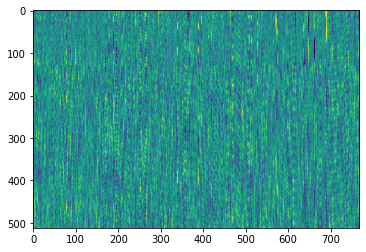

In [35]:
plt.imshow(model.bert.embeddings.position_embeddings.weight.detach().cpu().numpy(), vmin=-0.05, vmax=0.05)

In [36]:
model.bert.embeddings(torch.tensor([[1000,1002]]).to("cuda"))

tensor([[[-0.6767,  0.6250,  0.9545,  ...,  0.4151,  0.1406,  0.3705],
         [ 0.4629,  0.5397,  0.1355,  ..., -0.2454,  0.2921, -0.4961]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [37]:
model.bert.embeddings(torch.tensor([[1002,1000]]).to("cuda"))

tensor([[[ 0.4465,  0.4691,  0.1123,  ...,  0.0831,  0.2598, -0.4699],
         [-0.9721,  0.7282,  1.2025,  ...,  0.1829,  0.1353,  0.5788]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [38]:
p1 = model.bert.embeddings.position_embeddings(torch.tensor([[1]]).to("cuda"))

In [39]:
w1000 = model.bert.embeddings(torch.tensor([[1000]]).to("cuda"))

In [40]:
wemb = model.bert.embeddings.word_embeddings.weight

In [41]:
wemb.mean(axis=0).quantile(torch.tensor([0.1, 0.5, 0.9]).cuda())

tensor([-0.0173, -0.0003,  0.0120], device='cuda:0',
       grad_fn=<SqueezeBackward3>)

In [42]:
norm_wemb = wemb / wemb.norm(dim=1).unsqueeze(1)

In [50]:
vec

array([[ 0.04336363, -0.07245538, -0.03233318, -0.05984162, -0.0551384 ,
        -0.04096224, -0.0951279 , -0.0153762 , -0.0452906 ,  0.10796785,
         0.00310219,  0.07164854, -0.07221457,  0.0853902 ,  0.07170057,
         0.0015771 ,  0.07996657, -0.07635138,  0.07320246,  0.05087358,
         0.0489123 , -0.02061604, -0.04818725, -0.02354317,  0.06682882,
         0.03265832,  0.10887089,  0.09498688,  0.09922456,  0.05372157,
         0.00801122, -0.06858638,  0.14151096,  0.04039188, -0.046034  ,
         0.07460798, -0.06302945, -0.0255925 ,  0.00991111, -0.01534016,
         0.02937884, -0.11556862,  0.08580039, -0.06004775,  0.03319526,
         0.11440337, -0.10751615,  0.05087777,  0.1066275 , -0.03154048,
        -0.05391474, -0.11261313, -0.09074115, -0.04844984,  0.03238317,
         0.04415861,  0.12217653,  0.07746881, -0.03397751, -0.13198502,
         0.08220335,  0.06678544,  0.13503024, -0.05977662,  0.08559074,
        -0.0513431 , -0.10022166, -0.08780038, -0.0

In [43]:
tgt_idx = tokenizer.convert_tokens_to_ids(["房"])
sorted_idxs = torch.argsort(-torch.matmul(norm_wemb, norm_wemb[tgt_idx[0]]))
tokenizer.convert_ids_to_tokens(sorted_idxs[:20])

['房',
 '屋',
 '楼',
 '樓',
 '室',
 '墅',
 '店',
 '宅',
 'house',
 '住',
 'room',
 '院',
 '床',
 '##house',
 '车',
 '厅',
 '城',
 '居',
 '棚',
 '柜']